# Exploring the OSHA chemical monitoring dataset
### Author: Jeff Minucci
### Date: 9/9/2019

In [129]:
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tabulate import tabulate
%matplotlib inline

Using matplotlib backend: Qt5Agg


### Load the dataset

In [130]:
if not 'data/osha/osha_monitoring_1984_2018.zip':
    with zipfile.ZipFile('data/osha/osha_monitoring_1984_2018.zip','r') as zfile:
        zfile.extractall('data/osha')
osha = pd.read_csv('data/osha/osha_monitoring_1984_2018.csv')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,8,12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Clean and organize the data

In [150]:
osha.drop(osha.columns[0], axis=1, inplace=True) #drop first column of old indices
osha['imis_substance_code'] = osha['imis_substance_code'].astype('category')

# keep only samples with units of concentration, or that we can convert to concentrations
osha = osha[osha['unit_of_measurement'].isin(['M', 'P', "%"]) | ((osha['unit_of_measurement'].isin(['X', 'Y'])) & osha['air_volume_sampled']>0)]

# keep only  sample types P=personal, A=area, B=bulk
osha = osha[osha['sample_type'].isin(['P','A', 'B'])]

# convert all units to mg/m3
#osha_c = osha.copy()
#concentrations = np.empty(len(osha['sample_result']))
#for i, row in enumerate(df.iterrows()):
#    unit = row['unit_of_measurement']
#    if unit == 'Y': # mg
#        val = x/(row['air_volume_sampled']*0.001)
#    elif unit == 'X': # mcg
#        val = (x/1000)/(row['air_volume_sampled']*0.001)
#    elif unit == '%':
#        val = x * 10000000
#    elif unit == 'P':  # need m.w. to convert from ppm to mg/m3

# write cleaned dataset to file
#osha.to_csv('data/osha/osha_cleaned.csv')

### How many different chemicals have been sampled by osha?

In [151]:
osha.imis_substance_code.describe()

count     1880960
unique       1058
top          1591
freq       120347
Name: imis_substance_code, dtype: object

Ok so we have 1058 unique chemicals. 

How many substances occur frequently in the dataset?

In [146]:
thresholds = [2,10,50,100,500,1000, 5000, 10000]
counts = []
sub_counts = osha.imis_substance_code.value_counts()
for x in thresholds:
    counts.append(len(sub_counts[sub_counts >= x]))
print(tabulate({'Num of occurrences':thresholds, 'Num of substances':counts}, headers = 'keys', tablefmt='psql'))

+----------------------+---------------------+
|   Num of occurrences |   Num of substances |
|----------------------+---------------------|
|                    2 |                 985 |
|                   10 |                 659 |
|                   50 |                 389 |
|                  100 |                 289 |
|                  500 |                 147 |
|                 1000 |                 106 |
|                 5000 |                  47 |
|                10000 |                  32 |
+----------------------+---------------------+


Just a few substances are present an extremely large amount of times.

Let's look at the distribution when we remove these 'outliers'

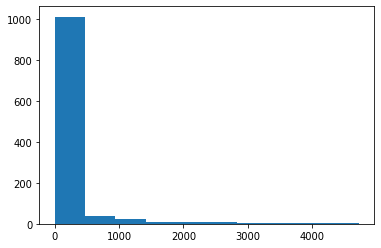

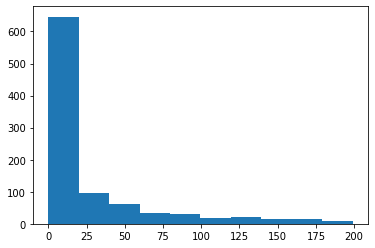

Median # of occurrences in osha monitoring: 15


In [147]:
sub_counts[sub_counts < 5000].hist(grid=False)
plt.show()
sub_counts[sub_counts < 200].hist(grid=False)
plt.show()
print('Median # of occurrences in osha monitoring: {:.0f}'.format(np.median(sub_counts)))

**IMIS code** isn't very meaningful without more info, but the substance column is poorly quality controlled, with some chemicals being named slightly differently.
Let's use fuzzy string matching to produce a list of the most commonly sampled substances by name.

In [108]:
counts_string = osha.substance.value_counts()
counts_string[counts_string < 1000].head()

Pyrene          977
DIACETYL        969
Isophorone      945
Phenanthrene    926
Cyclohexane     920
Name: substance, dtype: int64

In [160]:
# Write to csv a list of substance names
#substances = 
substance_list = osha.groupby('substance').count()
substance_list.to_csv('data/osha/substance_list.csv', header=True)

### What are the different units that sample measurements were taken in?

In [148]:
counts_units = osha.unit_of_measurement.value_counts()
counts_units.head(15)

M    1335322
P     310161
%     202162
Y      55366
X       1204
Name: unit_of_measurement, dtype: int64

In [122]:
osha[osha.sample_type=="['P', 'Y']"].tail()

,inspection_number,establishment_name,city,state,zip_code,sic_code,naics_code,sampling_number,office_id,date_sampled,...,sample_type,blank_used,time_sampled,air_volume_sampled,sample_weight,imis_substance_code,substance,sample_result,unit_of_measurement,qualifier
2114602,98775,Tompkins Aluminum Foundry Inc.,ROCK FALLS,IL,61071.0,NaN,331521.0,"['3284', '521400']",NaN,2012-JAN-26,...,"['P', 'Y']",NaN,NaN,NaN,0.0,G301,Gravimetric Determination,0.0,M,ND-BLK
2114603,98775,Tompkins Aluminum Foundry Inc.,ROCK FALLS,IL,61071.0,NaN,331521.0,"['3284', '521400']",NaN,2012-JAN-26,...,"['P', 'Y']",NaN,NaN,NaN,0.0,G302,Sample Weight,0.0,Y,ND-BLK
2114608,D28000,NaN,NaN,NaN,NaN,NaN,NaN,"['436522551', '215000']",NaN,2012-DEC-28,...,"['P', 'Y']",NaN,NaN,NaN,0.0,9135,Particulates not otherwise regulated (Total Dust),0.0,M,ND-BLK
2114609,D28000,NaN,NaN,NaN,NaN,NaN,NaN,"['436522551', '215000']",NaN,2012-DEC-28,...,"['P', 'Y']",NaN,NaN,NaN,0.0,G301,Gravimetric Determination,0.0,M,ND-BLK
2114610,D28000,NaN,NaN,NaN,NaN,NaN,NaN,"['436522551', '215000']",NaN,2012-DEC-28,...,"['P', 'Y']",NaN,NaN,NaN,0.0,G302,Sample Weight,0.0,Y,ND-BLK


In [128]:
osha[osha.unit_of_measurement=='N'].tail(25)

,inspection_number,establishment_name,city,state,zip_code,sic_code,naics_code,sampling_number,office_id,date_sampled,...,sample_type,blank_used,time_sampled,air_volume_sampled,sample_weight,imis_substance_code,substance,sample_result,unit_of_measurement,qualifier
2462567,1365892,NaN,NaN,NaN,NaN,NaN,NaN,331588,728500.0,2018-DEC-12,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2462672,1366399,NaN,NaN,NaN,NaN,NaN,NaN,323861,625500.0,2018-DEC-14,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2462800,1367048,NaN,NaN,NaN,NaN,NaN,NaN,332175,418100.0,2018-DEC-18,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2462992,1367373,NaN,NaN,NaN,NaN,NaN,NaN,332324,111700.0,2018-DEC-20,...,B,N,NaN,NaN,NaN,M123,QUALITATIVE MASS-SPEC ANALYSIS BY PYROLYSIS,0.00,N,BULK
2463032,1367401,NaN,NaN,NaN,NaN,NaN,NaN,333632,316700.0,2018-DEC-19,...,B,N,NaN,NaN,NaN,E101,Explosion Severity,0.00,N,NaN
2463048,1367524,NaN,NaN,NaN,NaN,NaN,NaN,332130,418200.0,2018-DEC-20,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2463076,1367711,NaN,NaN,NaN,NaN,NaN,NaN,332193,418400.0,2018-DEC-19,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2463077,1367711,NaN,NaN,NaN,NaN,NaN,NaN,332193,418400.0,2018-DEC-19,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2463078,1367711,NaN,NaN,NaN,NaN,NaN,NaN,332193,418400.0,2018-DEC-19,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN
2463133,1368112,NaN,NaN,NaN,NaN,NaN,NaN,332318,317000.0,2018-DEC-26,...,B,N,NaN,NaN,NaN,S777,Soil,0.00,N,NaN


In [90]:
osha

,inspection_number,establishment_name,city,state,zip_code,sic_code,naics_code,sampling_number,office_id,date_sampled,...,sample_type,blank_used,time_sampled,air_volume_sampled,sample_weight,imis_substance_code,substance,sample_result,unit_of_measurement,qualifier
0,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.24554e+06,214700.0,1984/05/07 00:00:00,...,P,N,258.0,516.0000,NaN,111211,Thorium,0.0005,M,NaN
1,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.24554e+06,214700.0,1984/05/07 00:00:00,...,P,Y,NaN,NaN,NaN,111211,Thorium,0.0000,NaN,BLK
2,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.2455e+06,214700.0,1984/05/07 00:00:00,...,P,N,38.0,76.0000,NaN,111211,Thorium,0.0160,M,NaN
3,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.2455e+06,214700.0,1984/05/07 00:00:00,...,P,Y,NaN,NaN,NaN,111211,Thorium,0.0000,NaN,BLK
4,111252,MID ISLAND NON FERROUS FOUNDRY,East Farmingdale,NY,11735.0,3365.0,0.0,5.24534e+06,214700.0,1984/04/04 00:00:00,...,P,N,37.0,74.0000,0.0,111252,"Lead, Inorganic (as Pb)",0.0640,M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463708,806189446,NaN,NaN,NaN,NaN,NaN,NaN,WA20180202B,1055300.0,2018-JAN-23,...,P,N,58.0,57.652,NaN,806189446,p-Phenylene Diamine,0.0000,M,ND
2463709,806189446,NaN,NaN,NaN,NaN,NaN,NaN,WA20180202B,1055300.0,2018-JAN-23,...,P,Y,NaN,NaN,NaN,806189446,p-Phenylene Diamine,0.0000,X,BLK
2463710,Q130304018,NaN,NaN,NaN,NaN,NaN,NaN,CA2018060401,950662.0,2018-MAY-31,...,B,N,NaN,NaN,NaN,Q130304018,Soil,0.0000,N,NaN
2463711,Q130304018,NaN,NaN,NaN,NaN,NaN,NaN,CA2018060401,950662.0,2018-MAY-31,...,B,N,NaN,NaN,NaN,Q130304018,Soil,0.0000,N,NaN
